In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#USE THIS DOCUMENTATION! IT'S MUCH BETTER:
#https://github.com/COEJKnight/five/blob/0777303f4bee60a10afaccbd0f5c56d880ad0059/usaspending_api/api_docs/api_documentation/advanced_award_search/spending_by_geography.md

In [3]:
url="https://api.usaspending.gov/api/v2/search/spending_by_geography/"
body = []
responses = []

In [4]:
#Don't change this
headers={'Content-Type':'application/json'}

#Removed because data not available before 2007: 2001, 2002, 2003, 2004, 2005, 2006.
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
#Do change this, depending on the filters that you want to apply (refer to the documentation link above to understand the parameters and output)
for year in years:
    body.append({
            "scope": "place_of_performance",
            "geo_layer": "state",
            #"geo_layer_filters":["MD","VA"],
            "filters": {
                "time_period": [
                    {
                        "start_date": f"{year}-10-01",
                        "end_date": f"{(year+1)}-09-30"
                    }
                    ]}
        })
#body[0] is equivalent to the object returned for year 0 which is 2001

In [5]:
#This is where we make the actual request to the API
for body in body:
    responses.append(requests.post(url, data=json.dumps(body),headers=headers).json())

#responses[0] is equivalent to body[0] which is equivalent to year[0]
#each of the details lines is there because earliest start date for pulls is 2007

responses

[{'scope': 'place_of_performance',
  'geo_layer': 'state',
  'results': [{'shape_code': 'AE',
    'aggregated_amount': 1234907.79,
    'display_name': 'None'},
   {'shape_code': 'AK',
    'aggregated_amount': 4123880794.55,
    'display_name': 'Alaska'},
   {'shape_code': 'AL',
    'aggregated_amount': 23320585479.59,
    'display_name': 'Alabama'},
   {'shape_code': 'AR',
    'aggregated_amount': 9320106146.95,
    'display_name': 'Arkansas'},
   {'shape_code': 'AS',
    'aggregated_amount': 118832800.83,
    'display_name': 'American Samoa'},
   {'shape_code': 'AZ',
    'aggregated_amount': 28687896817.94,
    'display_name': 'Arizona'},
   {'shape_code': 'CA',
    'aggregated_amount': 121806956465.5,
    'display_name': 'California'},
   {'shape_code': 'CO',
    'aggregated_amount': 17049548519.95,
    'display_name': 'Colorado'},
   {'shape_code': 'CT',
    'aggregated_amount': 21540917775.23,
    'display_name': 'Connecticut'},
   {'shape_code': 'DC',
    'aggregated_amount': 1923

In [6]:
# we need to build dataframe, keyed with the years list then enter the responses.json, 
# pull aggregated amount for each relevant state plus shape code(to check) 
# use for loop to get each state's info into DF. 

aggregates =[]
counter = 0

for year in years:
    dataframe = pd.DataFrame(responses[counter]["results"])
    dataframe["year"] = year
    aggregates.append(dataframe)
    counter+=1

aggregates

[   shape_code  aggregated_amount                    display_name  year
 0          AE       1.234908e+06                            None  2007
 1          AK       4.123881e+09                          Alaska  2007
 2          AL       2.332059e+10                         Alabama  2007
 3          AR       9.320106e+09                        Arkansas  2007
 4          AS       1.188328e+08                  American Samoa  2007
 5          AZ       2.868790e+10                         Arizona  2007
 6          CA       1.218070e+11                      California  2007
 7          CO       1.704955e+10                        Colorado  2007
 8          CT       2.154092e+10                     Connecticut  2007
 9          DC       1.923171e+10            District Of Columbia  2007
 10         DE       2.722588e+09                        Delaware  2007
 11         FL       6.546991e+10                         Florida  2007
 12         FM       1.080268e+07  Federated States Of Micronesi

In [7]:
#Pulls aggregates list into single DF

agg_concat = pd.concat(aggregates).reset_index(drop=True)
agg_concat["agg_billions"] = (agg_concat["aggregated_amount"]/1000000000).round(decimals=3)

agg_concat

,shape_code,aggregated_amount,display_name,year,agg_billions
0,AE,1.234908e+06,None,2007,0.001
1,AK,4.123881e+09,Alaska,2007,4.124
2,AL,2.332059e+10,Alabama,2007,23.321
3,AR,9.320106e+09,Arkansas,2007,9.320
4,AS,1.188328e+08,American Samoa,2007,0.119
...,...,...,...,...,...
773,VT,1.329844e+09,Vermont,2019,1.330
774,WA,1.499228e+10,Washington,2019,14.992
775,WI,2.339714e+10,Wisconsin,2019,23.397
776,WV,5.500846e+09,West Virginia,2019,5.501


In [8]:
#focusing on states with longest serving senators.
states = ["CA", "VT", "IA", "AL", "KY", "WA"]
agg_clean = agg_concat[agg_concat["shape_code"].isin(states)]
agg_clean.reset_index(inplace=True, drop=True)

#drops aggregate_amount
agg_clean.drop(columns="aggregated_amount",inplace=True)

agg_clean.head(6)

/Users/ericamatrese/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,shape_code,display_name,year,agg_billions
0,AL,Alabama,2007,23.321
1,CA,California,2007,121.807
2,IA,Iowa,2007,9.602
3,KY,Kentucky,2007,18.290
4,VT,Vermont,2007,2.230
5,WA,Washington,2007,25.144


In [9]:
# Establish Senator classes. Source: https://en.wikipedia.org/wiki/Classes_of_United_States_senators
# Note there is redundancy between the classes, because each state has two Senators.
# Establish election years by class.

class_1_str = "Arizona, California, Connecticut, Delaware, Florida, Hawaii, Indiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New Jersey, New Mexico, New York, North Dakota, Ohio, Pennsylvania, Rhode Island, Tennessee, Texas, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming"
class_2_str = "Alabama, Alaska, Arkansas, Colorado, Delaware, Georgia, Idaho, Illinois, Iowa, Kansas, Kentucky, Louisiana, Maine, Massachusetts, Michigan, Minnesota, Mississippi, Montana, Nebraska, New Hampshire, New Jersey, New Mexico, North Carolina, Oklahoma, Oregon, Rhode Island, South Carolina, South Dakota, Tennessee, Texas, Virginia, West Virginia, Wyoming"
class_3_str = "Alabama, Alaska, Arizona, Arkansas, California, Colorado, Connecticut, Florida, Georgia, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maryland, Missouri, Nevada, New Hampshire, New York, North Carolina, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, South Carolina, South Dakota, Utah, Vermont, Washington, Wisconsin"

def list_split(string):
    output = list(string.split(", "))
    return output

class_1 = list_split(class_1_str)
class_2 = list_split(class_2_str)
class_3 = list_split(class_3_str)

us_state_abrv = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
class_1_abrv = [(us_state_abrv[state]) for state in class_1]
class_2_abrv = [(us_state_abrv[state]) for state in class_2]
class_3_abrv = [(us_state_abrv[state]) for state in class_3]

class_1_years = [2018, 2012,2006]
class_2_years = [2020, 2014,2008]
class_3_years = [2016, 2010]

# print(class_1_abrv,class_2_abrv,class_3_abrv)

In [10]:
# Establish aggregate amounts by class. "In YEAR Class 1 had this amount of aggregate spend, in YEAR+1, etc"
agg_concat["class_1"] = agg_concat["shape_code"].isin(class_1_abrv)
agg_concat["class_2"] = agg_concat["shape_code"].isin(class_2_abrv)
agg_concat["class_3"] = agg_concat["shape_code"].isin(class_3_abrv)

agg_concat

,shape_code,aggregated_amount,display_name,year,agg_billions,class_1,class_2,class_3
0,AE,1.234908e+06,None,2007,0.001,False,False,False
1,AK,4.123881e+09,Alaska,2007,4.124,False,True,True
2,AL,2.332059e+10,Alabama,2007,23.321,False,True,True
3,AR,9.320106e+09,Arkansas,2007,9.320,False,True,True
4,AS,1.188328e+08,American Samoa,2007,0.119,False,False,False
...,...,...,...,...,...,...,...,...
773,VT,1.329844e+09,Vermont,2019,1.330,True,False,True
774,WA,1.499228e+10,Washington,2019,14.992,True,False,True
775,WI,2.339714e+10,Wisconsin,2019,23.397,True,False,True
776,WV,5.500846e+09,West Virginia,2019,5.501,True,True,False


Text(0.5, 1.0, '6 Senator States')

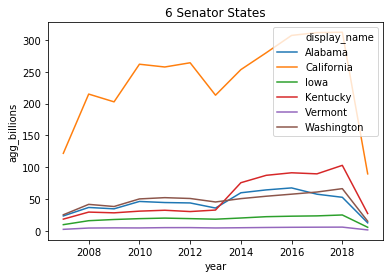

In [31]:
#6 Senator Specific 

#agg_clean[agg_clean["shape_code"]== "AL"]
state_mask = agg_clean["shape_code"].isin(["AL","CA","IA","KY","VT","WA"])
agg_clean[state_mask]


#States Line graph (6)

sns.lineplot(x="year", y="agg_billions", data=agg_clean[state_mask],hue= "display_name").set_title("6 Senator States")